In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon

df = pd.read_pickle(r'.\data\normalized_data.pkl')

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
# Define the features we will use
feature_columns = ['latitude', 'longitude', 'VV_soil', 'VH_soil', 'NDVI', 'NDMI', 'B1', 'B10',
       'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 
       'landsat_NDVI', 
       'landsat_NDMI', 'landsat_B1', 'landsat_B2', 'landsat_B3', 'landsat_B4', 'landsat_B5', 
       'landsat_B6', 'landsat_B7', 'landsat_B8', 'landsat_B9', 'landsat_B10', 'landsat_B11', 
       'DSM']

# Define the label we will use
target_column = 'soil_moisture'

shuffled_df = df.sample(frac=1).reset_index(drop=True)
features = shuffled_df[feature_columns]
target = shuffled_df[target_column]


In [ ]:
for column in feature_columns:
    shuffled_df[column] = pd.to_numeric(shuffled_df[column], errors='coerce')

# Handle missing values, for example, by filling with 0 or column mean
shuffled_df.dropna()

,station,datetime,soil_moisture,latitude,longitude,VV,VH,angle,NDVI,NDMI,...,landsat_B6,landsat_B7,landsat_B8,landsat_B9,landsat_B10,landsat_B11,DSM,koppen_class,VV_soil,VH_soil
0,MCCLELLANVILLE-7-NE,2022-05-06 23:00:00,0.0490,0.033153,-0.079364,-15.525184,-17.148355,0.633795,0.362877,-0.062410,...,0.216923,0.218261,0.216923,0.218261,0.298134,0.296562,-0.989175,0.08,0.073716,0.060385
1,Fallbrook-5-NE,2021-03-25 13:00:00,0.2120,0.033439,-0.117190,-10.897289,-19.925462,-0.421611,0.262066,-0.153784,...,0.198509,0.145082,0.198509,0.145082,0.294610,0.294569,-0.815426,0.05,0.178651,-0.030024
2,ITHACA-13-E,2022-11-11 22:00:00,0.3460,0.042440,-0.076246,-8.070395,-14.420784,0.010330,0.564133,0.036396,...,0.250845,0.364274,0.250845,0.364274,0.282963,0.283003,-0.858728,0.18,0.284283,0.174871
3,Merced-23-WSW,2020-09-24 14:00:00,0.1730,0.037238,-0.120882,-15.141834,-20.908614,-0.144241,0.190409,-0.200909,...,0.301186,0.255093,0.301186,0.255093,0.306256,0.304161,-0.962111,0.05,0.072449,-0.060700
4,SAA111,2020-07-10 04:00:00,0.2380,0.068330,0.027551,-12.932057,-17.213182,0.393456,0.350475,-0.161385,...,0.131310,0.147104,0.131310,0.147104,0.280272,0.280174,-0.753721,0.19,0.138106,0.054755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183159,JOHN-DAY-35-WNW,2023-02-01 01:00:00,0.1120,0.044556,-0.119646,-14.127961,-27.708919,0.178495,0.187416,-0.192719,...,0.237048,0.252277,0.237048,0.252277,0.270063,0.270344,-0.458728,0.05,0.096776,-0.230514
183160,LA-JUNTA-17-WSW,2021-04-07 00:00:00,0.2240,0.037864,-0.103822,-17.497676,-28.055488,0.095766,0.110434,-0.154429,...,0.376204,0.296439,0.376204,0.296439,0.303804,0.302978,-0.184303,0.05,0.012726,-0.238341
183161,PANTHER-JUNCTION-2-N,2018-07-16 00:00:00,0.1140,0.029348,-0.103209,-7.618855,-16.079348,-0.780462,0.104252,-0.071332,...,0.275530,0.264145,0.275530,0.264145,0.307313,0.304131,-0.405683,0.06,0.247334,0.046440
183162,Silver-Springs,2017-03-14 19:00:00,0.0274,-0.035272,0.147429,-17.864517,-22.273885,0.244956,0.154501,-0.258832,...,0.423276,0.282650,0.423276,0.282650,0.307754,0.304653,-0.821380,0.08,0.005800,-0.096422


In [ ]:
X = shuffled_df[feature_columns].values.astype(np.float32)
y = shuffled_df[target_column].values.astype(np.float32)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
import numpy as np

np.savez("train_test_data.npz", 
         X_train=X_train, 
         X_test=X_test, 
         y_train=y_train, 
         y_test=y_test)


In [ ]:
data = np.load("train_test_data.npz")
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']


In [ ]:
import numpy as np
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from tqdm import tqdm
import itertools
from sklearn.model_selection import KFold

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_list, bias_list, rmse_list, ubrmse_list = [], [], [], []

for train_index, val_index in tqdm(kf.split(X), desc="Random Forest 5-Fold CV"):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]

    # Train with best parameters
    rf_model = RandomForestRegressor(
        n_estimators=2500,
        max_depth=32,
        min_samples_split=3,
        min_samples_leaf=7,
        max_features=None,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = rf_model.predict(X_val_cv)

    # Compute metrics
    bias = np.mean(y_pred_cv - y_val_cv)
    rmse = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
    r2 = r2_score(y_val_cv, y_pred_cv)
    ubrmse = np.sqrt(np.mean((y_pred_cv - y_val_cv - bias) ** 2))

    # Store results
    r2_list.append(r2)
    bias_list.append(bias)
    rmse_list.append(rmse)
    ubrmse_list.append(ubrmse)

# === Print average 5-fold CV results ===
print("\n✅ Random Forest Average Accuracy from 5-Fold Cross-Validation")
print(f" R²:      {np.mean(r2_list):.4f}")
print(f" Bias:    {np.mean(bias_list):.4f}")
print(f" RMSE:    {np.mean(rmse_list):.4f}")
print(f" ubRMSE:  {np.mean(ubrmse_list):.4f}")

Random Forest 5-Fold CV: 5it [30:33, 366.62s/it]


✅ Random Forest Average Accuracy from 5-Fold Cross-Validation
 R²:      0.7725
 Bias:    0.0002
 RMSE:    0.0510
 ubRMSE:  0.0510


In [ ]:
import joblib

joblib.dump(rf_model, "./models/rf_model.pkl")
print("📌 Model saved!")

📌 Model saved!


In [8]:
import numpy as np
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Only scale the target (y) ===
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))

# === TabNet Parameters ===
best_params_tabnet = {
    'n_d': 256,
    'n_a': 256,
    'n_steps': 3,
    'gamma': 1.1431511685851061,
    'lambda_sparse': 1.0095158720555385e-05,
    'lr': 0.004029628042947173
}

# === Cross-validation setup ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_list, rmse_list, bias_list, ubrmse_list = [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n📂 Fold {fold+1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_scaled[train_idx], y_scaled[val_idx]

    tabnet_model = TabNetRegressor(
        n_d=best_params_tabnet['n_d'],
        n_a=best_params_tabnet['n_a'],
        n_steps=best_params_tabnet['n_steps'],
        gamma=best_params_tabnet['gamma'],
        lambda_sparse=best_params_tabnet['lambda_sparse'],
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=best_params_tabnet['lr']),
        verbose=0
    )

    tabnet_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric=['rmse'],
        max_epochs=200,
        patience=50,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

    # Inverse-transform predictions and targets
    y_pred = tabnet_model.predict(X_val)
    y_pred = y_scaler.inverse_transform(y_pred)
    y_true = y_scaler.inverse_transform(y_val)

    # Metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    ubrmse = np.sqrt(np.mean((y_pred - y_true - bias)**2))

    r2_list.append(r2)
    rmse_list.append(rmse)
    bias_list.append(bias)
    ubrmse_list.append(ubrmse)

    print(f" R²: {r2:.4f}, RMSE: {rmse:.4f}, Bias: {bias:.4f}, ubRMSE: {ubrmse:.4f}")

# === Final average metrics ===
print("\n✅ Final 5-Fold Cross-Validation Results")
print(f"Average R²: {np.mean(r2_list):.4f}")
print(f"Average RMSE: {np.mean(rmse_list):.4f}")
print(f"Average Bias: {np.mean(bias_list):.4f}")
print(f"Average ubRMSE: {np.mean(ubrmse_list):.4f}")


📂 Fold 1

Early stopping occurred at epoch 197 with best_epoch = 147 and best_val_0_rmse = 0.47351


c:\Users\jiyuc\anaconda3\envs\myenv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


 R²: 0.7752, RMSE: 0.0506, Bias: -0.0007, ubRMSE: 0.0506

📂 Fold 2

Early stopping occurred at epoch 162 with best_epoch = 112 and best_val_0_rmse = 0.47366


c:\Users\jiyuc\anaconda3\envs\myenv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


 R²: 0.7743, RMSE: 0.0506, Bias: -0.0012, ubRMSE: 0.0506

📂 Fold 3
Stop training because you reached max_epochs = 200 with best_epoch = 165 and best_val_0_rmse = 0.47342


c:\Users\jiyuc\anaconda3\envs\myenv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


 R²: 0.7773, RMSE: 0.0506, Bias: -0.0014, ubRMSE: 0.0506

📂 Fold 4

Early stopping occurred at epoch 182 with best_epoch = 132 and best_val_0_rmse = 0.47717


c:\Users\jiyuc\anaconda3\envs\myenv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


 R²: 0.7722, RMSE: 0.0510, Bias: 0.0020, ubRMSE: 0.0510

📂 Fold 5

Early stopping occurred at epoch 180 with best_epoch = 130 and best_val_0_rmse = 0.4707


c:\Users\jiyuc\anaconda3\envs\myenv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


 R²: 0.7790, RMSE: 0.0503, Bias: -0.0002, ubRMSE: 0.0503

✅ Final 5-Fold Cross-Validation Results
Average R²: 0.7756
Average RMSE: 0.0506
Average Bias: -0.0003
Average ubRMSE: 0.0506


In [ ]:
import joblib

joblib.dump(tabnet_model, "./models/tabnet_model.pkl")
joblib.dump(y_scaler, './models/tabnet_target_scaler.pkl')
print("📌 Model saved!")

📌 Model with reduced feature influence saved!


In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import itertools

X = shuffled_df[feature_columns].values.astype(np.float32)
y = shuffled_df[target_column].values.astype(np.float32)

# Split the dataset (same as RF)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 2: Define XGBoost and hyperparameter grid ===
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [2500],
    'max_depth': [19],
    'learning_rate': [0.1],
    'subsample': [0.6536],
    'colsample_bytree': [0.5849]
}

# === Step 3: Wrap param grid in tqdm ===
param_grid_list = list(itertools.product(*param_grid.values()))
param_grid_iterable = tqdm(param_grid_list, desc="XGBoost Grid Search", total=len(param_grid_list))

# === Step 4: Perform grid search with 5-fold CV ===
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=0
)

grid_search.fit(X_train, y_train)

# === Step 5: Evaluate best model ===
print("Best parameters found:", grid_search.best_params_)

xgb_model = grid_search.best_estimator_

xgb_predictions = xgb_model.predict(X_test)

# === Calculate evaluation metrics ===
xgb_bias = np.mean(xgb_predictions - y_test.ravel())
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)
xgb_error = xgb_predictions - y_test.ravel()
xgb_ubrmse = np.sqrt(np.mean((xgb_error - xgb_bias) ** 2))

# === Print final metrics ===
print("\n✅ XGBoost Final Evaluation on Held-Out Test Set")
print(f" R²:      {xgb_r2:.4f}")
print(f" Bias:    {xgb_bias:.4f}")
print(f" RMSE:    {xgb_rmse:.4f}")
print(f" ubRMSE:  {xgb_ubrmse:.4f}")


XGBoost Grid Search:   0%|          | 0/1 [00:00<?, ?it/s]

Best parameters found: {'colsample_bytree': 0.5849, 'learning_rate': 0.1, 'max_depth': 19, 'n_estimators': 2500, 'subsample': 0.6536}

✅ XGBoost Final Evaluation on Held-Out Test Set
 R²:      0.6792
 Bias:    0.0001
 RMSE:    0.0603
 ubRMSE:  0.0603


In [ ]:
import joblib

joblib.dump(best_xgb_model, "./models/xgb_model.pkl")
print("📌 Model saved!")

📌 Model saved!


[I 2025-05-05 15:47:10,252] A new study created in memory with name: no-name-68936bfa-5180-42bc-87f9-875f2504c0ad
[I 2025-05-05 15:47:27,984] Trial 0 finished with value: 0.041099311595144496 and parameters: {'tabnet_weight': 0.012446951935725759, 'rf_weight': 0.7575429739734009, 'xgb_weight': 0.14850544577447788}. Best is trial 0 with value: 0.041099311595144496.
[I 2025-05-05 15:47:48,183] Trial 1 finished with value: 0.036426224760481546 and parameters: {'tabnet_weight': 0.1858276441989748, 'rf_weight': 0.5171890903034271, 'xgb_weight': 0.6179284412088996}. Best is trial 1 with value: 0.036426224760481546.
[I 2025-05-05 15:48:08,545] Trial 2 finished with value: 0.03850927631612466 and parameters: {'tabnet_weight': 0.2643586765659852, 'rf_weight': 0.7695248443811917, 'xgb_weight': 0.42045303238244824}. Best is trial 1 with value: 0.036426224760481546.
[I 2025-05-05 15:48:27,540] Trial 3 finished with value: 0.037855057120775235 and parameters: {'tabnet_weight': 0.5307974549582698, '


✅ Best Normalized Weights:
 tabnet_weight: 0.0023
 rf_weight: 0.1010
 xgb_weight: 0.8967

📊 Ensemble Model Metrics:
 R²     = 0.7069
 Bias   = 0.0001
 RMSE   = 0.0576
 ubRMSE = 0.0576
 Pearson= 0.8462


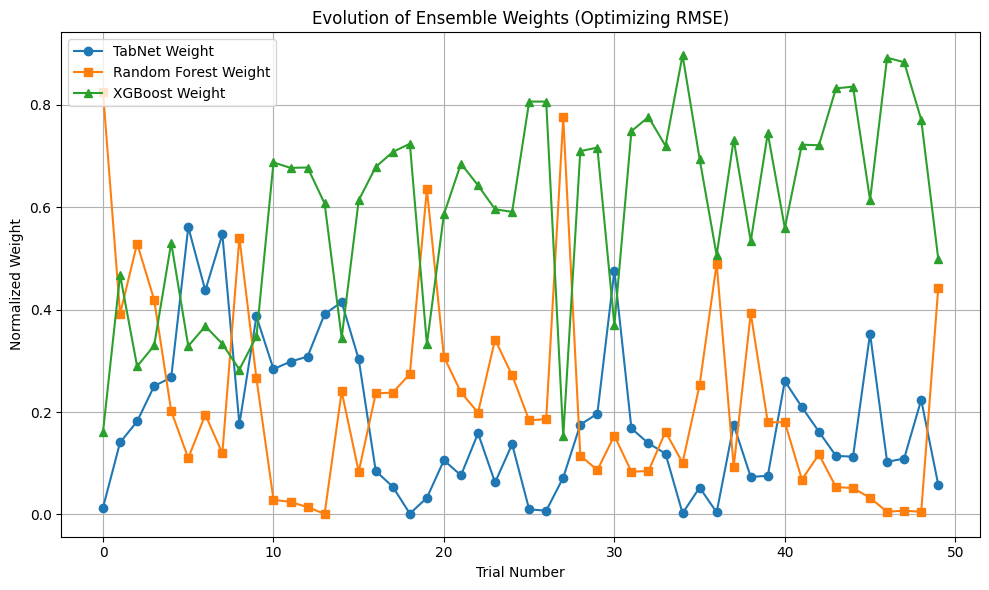

In [ ]:
import numpy as np
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
import joblib
import torch
import matplotlib.pyplot as plt

# === Load trained models and scaler ===
tabnet_model = joblib.load("./models/tabnet_model.pkl")
target_scaler = joblib.load("./models/tabnet_target_scaler_.pkl")
rf_model = joblib.load("./models/rf_model.pkl")
xgb_model = joblib.load("./models/xgb_model.pkl")

# === Evaluation function ===
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    bias = np.mean(y_pred - y_true)
    ubrmse = np.sqrt(np.mean(((y_pred - y_true) - bias) ** 2))
    pearson, _ = pearsonr(y_true.flatten(), y_pred.flatten())
    print(f"\n📊 {model_name} Metrics:")
    print(f" R²     = {r2:.4f}")
    print(f" Bias   = {bias:.4f}")
    print(f" RMSE   = {rmse:.4f}")
    print(f" ubRMSE = {ubrmse:.4f}")
    print(f" Pearson= {pearson:.4f}")

# === Optuna objective that minimizes RMSE ===
def objective(trial, X_train, y_train):
    tabnet_weight = trial.suggest_float('tabnet_weight', 0, 1)
    rf_weight = trial.suggest_float('rf_weight', 0, 1)
    xgb_weight = trial.suggest_float('xgb_weight', 0, 1)

    total_weight = tabnet_weight + rf_weight + xgb_weight
    tabnet_weight /= total_weight
    rf_weight /= total_weight
    xgb_weight /= total_weight

    trial.set_user_attr("normalized_tabnet_weight", tabnet_weight)
    trial.set_user_attr("normalized_rf_weight", rf_weight)
    trial.set_user_attr("normalized_xgb_weight", xgb_weight)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_val = X_train[val_idx]
        y_val = y_train[val_idx].reshape(-1, 1)

        with torch.no_grad():
            tabnet_preds = tabnet_model.predict(X_val)
        tabnet_preds = target_scaler.inverse_transform(tabnet_preds).reshape(-1, 1)

        rf_preds = rf_model.predict(X_val).reshape(-1, 1)
        xgb_preds = xgb_model.predict(X_val).reshape(-1, 1)

        ensemble_preds = (
            tabnet_weight * tabnet_preds +
            rf_weight * rf_preds +
            xgb_weight * xgb_preds
        )

        rmse = np.sqrt(mean_squared_error(y_val, ensemble_preds))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

# === Run Optuna ===
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

# === Get best weights ===
best_weights = study.best_params
total = sum(best_weights.values())
best_weights = {k: v / total for k, v in best_weights.items()}

print("\n✅ Best Normalized Weights:")
for model, weight in best_weights.items():
    print(f" {model}: {weight:.4f}")

# === Evaluate ensemble on test set ===
with torch.no_grad():
    tabnet_preds_test = tabnet_model.predict(X_test)
tabnet_preds_test = target_scaler.inverse_transform(tabnet_preds_test).reshape(-1, 1)
rf_preds_test = rf_model.predict(X_test).reshape(-1, 1)
xgb_preds_test = xgb_model.predict(X_test).reshape(-1, 1)
y_true_test = y_test.reshape(-1, 1)

ensemble_preds_test = (
    best_weights['tabnet_weight'] * tabnet_preds_test +
    best_weights['rf_weight'] * rf_preds_test +
    best_weights['xgb_weight'] * xgb_preds_test
)

evaluate_model(y_true_test, ensemble_preds_test, "Ensemble Model")

# === Plot weight evolution across trials ===
tabnet_weights = []
rf_weights = []
xgb_weights = []

for t in study.trials:
    if t.state.name == "COMPLETE":
        tabnet_weights.append(t.user_attrs.get("normalized_tabnet_weight", np.nan))
        rf_weights.append(t.user_attrs.get("normalized_rf_weight", np.nan))
        xgb_weights.append(t.user_attrs.get("normalized_xgb_weight", np.nan))

plt.figure(figsize=(10, 6))
plt.plot(tabnet_weights, label="TabNet Weight", marker='o')
plt.plot(rf_weights, label="Random Forest Weight", marker='s')
plt.plot(xgb_weights, label="XGBoost Weight", marker='^')
plt.xlabel("Trial Number")
plt.ylabel("Normalized Weight")
plt.title("Evolution of Ensemble Weights (Optimizing RMSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import torch
import joblib

tabnet_model = joblib.load("./models/tabnet_model.pkl")
target_scaler = joblib.load("./models/tabnet_target_scaler_.pkl")
rf_model = joblib.load("./models/rf_model.pkl")
xgb_model = joblib.load("./models/xgb_model.pkl")

# === Load predictions for the test set ===
with torch.no_grad():
    tabnet_preds_test = tabnet_model.predict(X_test)
tabnet_preds_test = target_scaler.inverse_transform(tabnet_preds_test).reshape(-1, 1)

rf_preds_test = rf_model.predict(X_test).reshape(-1, 1)
xgb_preds_test = xgb_model.predict(X_test).reshape(-1, 1)
y_true_test = y_test.reshape(-1, 1)

# === Use fixed weights ===
weights = {'rf': 0.56, 'tabnet': 0.43, 'xgb': 0.26}
total_weight = sum(weights.values())
normalized_weights = {k: v / total_weight for k, v in weights.items()}

# === Apply weights to ensemble prediction ===
ensemble_preds_test = (
    normalized_weights['rf'] * rf_preds_test +
    normalized_weights['tabnet'] * tabnet_preds_test +
    normalized_weights['xgb'] * xgb_preds_test
)

# === Calculate metrics ===
def compute_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    ubrmse = np.sqrt(np.mean(((y_pred - y_true) - bias) ** 2))
    
    print("✅ Ensemble Metrics (Fixed Weights)")
    print(f"R²:     {r2:.4f}")
    print(f"Bias:   {bias:.4f}")
    print(f"RMSE:   {rmse:.4f}")
    print(f"ubRMSE: {ubrmse:.4f}")
    
    return {'r2': r2, 'bias': bias, 'rmse': rmse, 'ubrmse': ubrmse}

# === Output final metrics ===
metrics = compute_metrics(y_true_test, ensemble_preds_test)


✅ Ensemble Metrics (Fixed Weights)
R²:     0.8591
Bias:   -0.0002
RMSE:   0.0401
ubRMSE: 0.0401



📊 TabNet
R²:     0.8302
Bias:   -0.0006
RMSE:   0.0440
ubRMSE: 0.0440


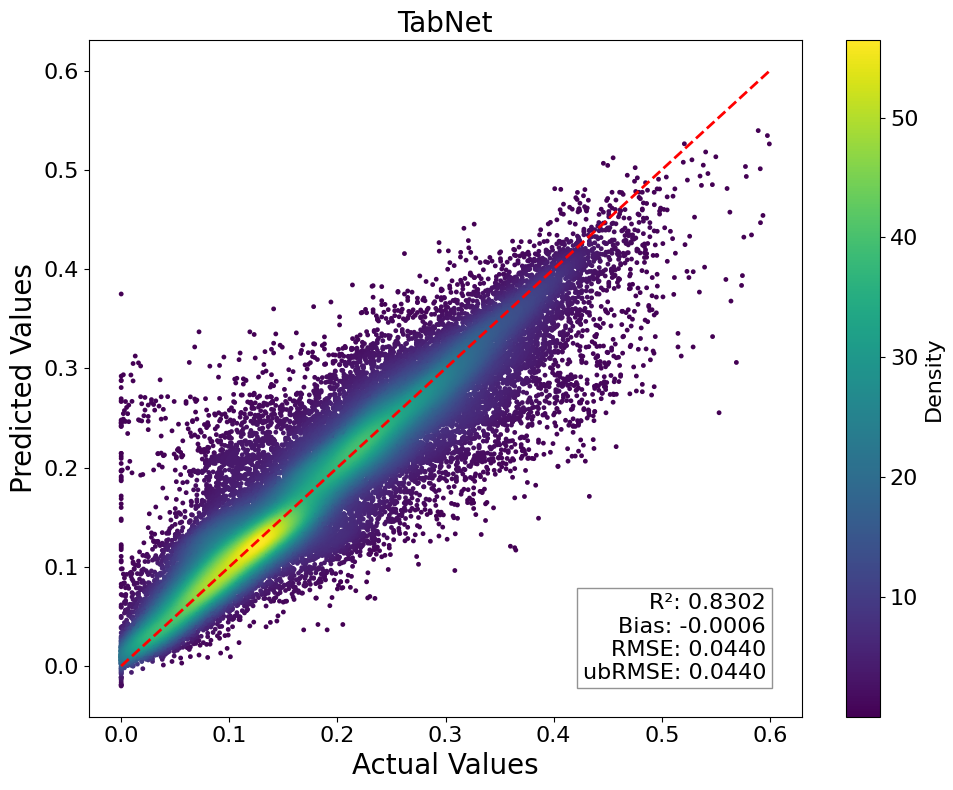


📊 Random Forest
R²:     0.8346
Bias:   -0.0000
RMSE:   0.0434
ubRMSE: 0.0434


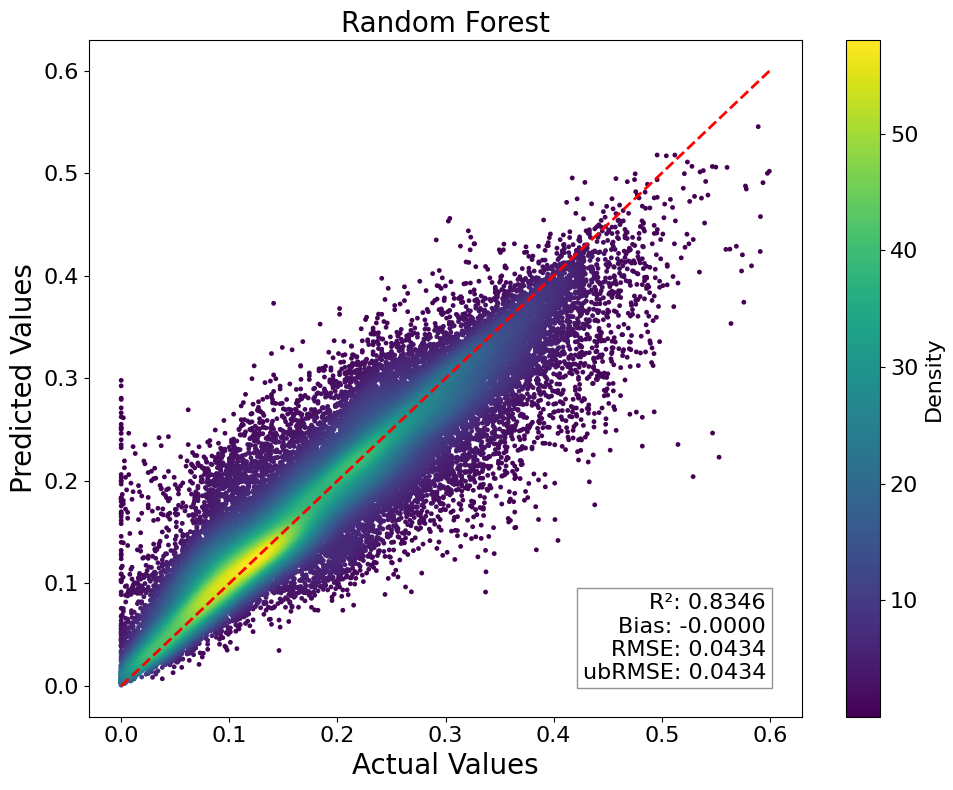


📊 XGBoost
R²:     0.8586
Bias:   -0.0002
RMSE:   0.0401
ubRMSE: 0.0401


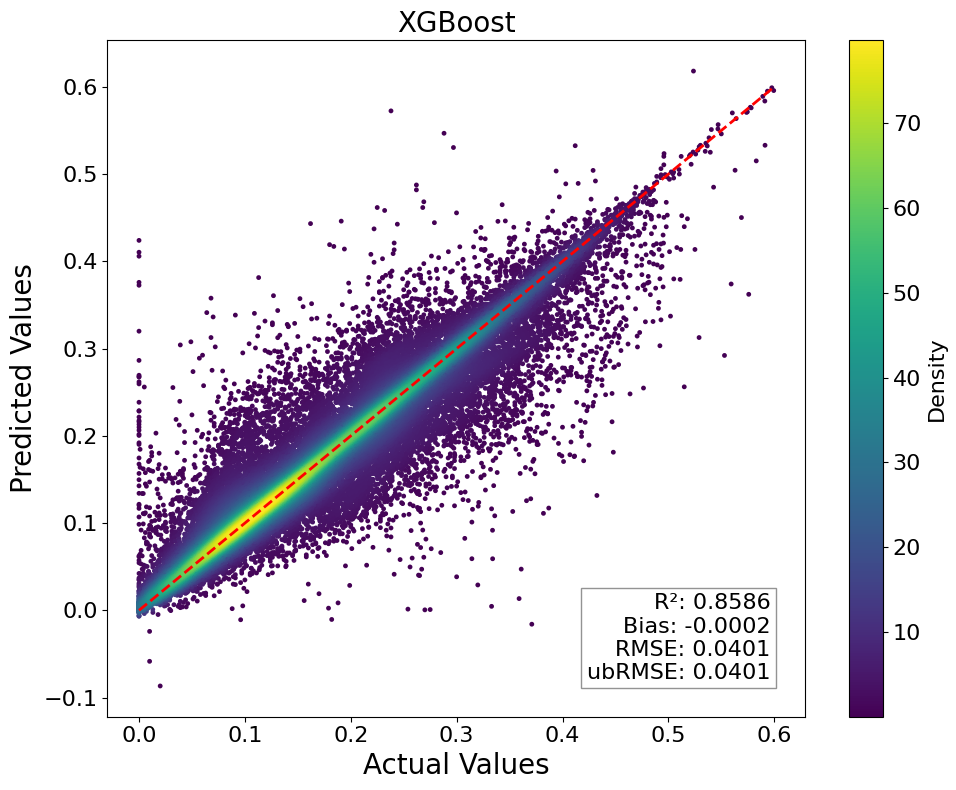


📊 Ensemble Model
R²:     0.8591
Bias:   -0.0002
RMSE:   0.0401
ubRMSE: 0.0401


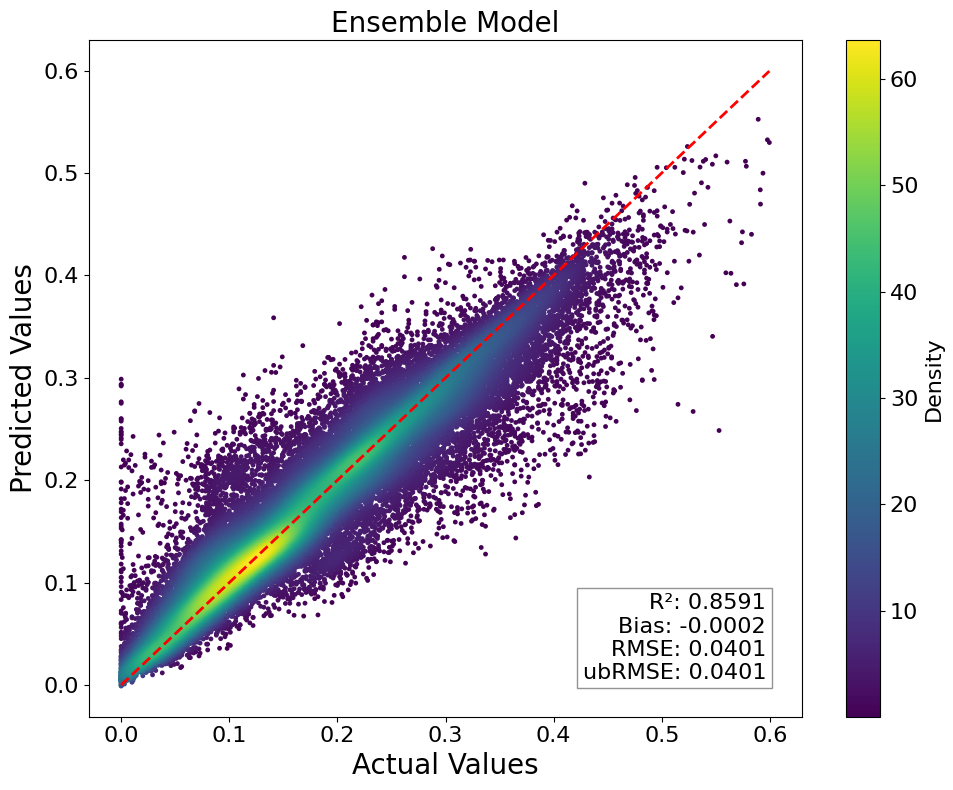

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import gaussian_kde

def evaluate_model(y_true, y_pred, model_name):
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()

    # === Calculate metrics ===
    r2 = r2_score(y_true, y_pred)
    error = y_pred - y_true
    bias = np.mean(error)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    ubrmse = np.sqrt(np.mean((error - bias) ** 2))

    # === Print metrics ===
    print(f"\n📊 {model_name}")
    print(f"R²:     {r2:.4f}")
    print(f"Bias:   {bias:.4f}")
    print(f"RMSE:   {rmse:.4f}")
    print(f"ubRMSE: {ubrmse:.4f}")
    print("=" * 50)

    # === Estimate density ===
    xy = np.vstack([y_true, y_pred])
    z = gaussian_kde(xy)(xy)

    # === Sort points by density ===
    idx = z.argsort()
    x, y, z = y_true[idx], y_pred[idx], z[idx]

    # === Plot ===
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(x, y, c=z, s=12, cmap='viridis', edgecolor='none')
    plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', lw=2, label='1:1 Line')

    # === Text box with metrics ===
    metrics_text = (
        f"R²: {r2:.4f}\n"
        f"Bias: {bias:.4f}\n"
        f"RMSE: {rmse:.4f}\n"
        f"ubRMSE: {ubrmse:.4f}"
    )
    plt.text(0.95, 0.05, metrics_text, fontsize=16, ha='right', va='bottom',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.85, edgecolor='gray'))

    # === Final style ===
    plt.xlabel("Actual Values", fontsize=20)
    plt.ylabel("Predicted Values", fontsize=20)
    plt.title(f"{model_name}", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(False)
    cbar = plt.colorbar(sc)
    cbar.set_label('Density', fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    plt.tight_layout()
    plt.show()

# Call for each model
evaluate_model(y_test, tabnet_preds_test, "TabNet")
evaluate_model(y_test, rf_preds_test, "Random Forest")
evaluate_model(y_test, xgb_preds_test, "XGBoost")
evaluate_model(y_test, ensemble_preds_test, "Ensemble Model")


In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
